## 1. What is the dependent variable you decided?

"Suicides/100k pop" is the most defendable for this assignment. It describes what we are (generally speaking) most intrested in from this data, is normalized, and is non-imputed. 


In [1]:
# Load libraries and dataset
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from os.path import isfile
from itertools import product

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier


sns.set(style='ticks', color_codes=True)

data_path = './datasets/Suicide_Rates.csv'

suicides = pd.DataFrame()
if not isfile(data_path):
    print("Dataset not found. Please check that the dataset exists and the path is correct.")
    
else:
    suicides = pd.read_csv(data_path)
    
    
# GDP per year is recorded as strings and not ints so fix that real quick
suicides = suicides.rename(columns={' gdp_for_year ($) ': 'gdp_for_year ($)'})

suicides['gdp_for_year ($)'] = suicides['gdp_for_year ($)'].str.replace(',', '')
suicides['gdp_for_year ($)'] = suicides['gdp_for_year ($)'].apply(int)

display(suicides)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,2156624900,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,2156624900,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,2156624900,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,2156624900,796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,63067077179,2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,63067077179,2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,63067077179,2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,63067077179,2309,Generation Z


In [2]:
# Impute
HDI_mean = suicides['HDI for year'].mean() # used in part 5
suicides['HDI for year'] = suicides['HDI for year'].fillna(HDI_mean)

# Adapted from Assignment 3 soln.
# Discretize
def discretize(df):
    df['sex'] = df['sex'].replace({
        'female':0,
        'male':1})
    df['age'] = df['age'].replace({
        '5-14 years':10,
        '15-24 years':20,
        '25-34 years':30,
        '35-54 years':45,
        '55-74 years':65,
        '75+ years':80})
    df['generation'] = df['generation'].replace({
        'G.I. Generation':1,
        'Silent':2,
        'Boomers':3,
        'Generation X':4,
        'Millenials':5,
        'Generation Z':6})
    
    return df

suicides = discretize(suicides)

# make a copy for data vis.
suicides_org = suicides.copy()

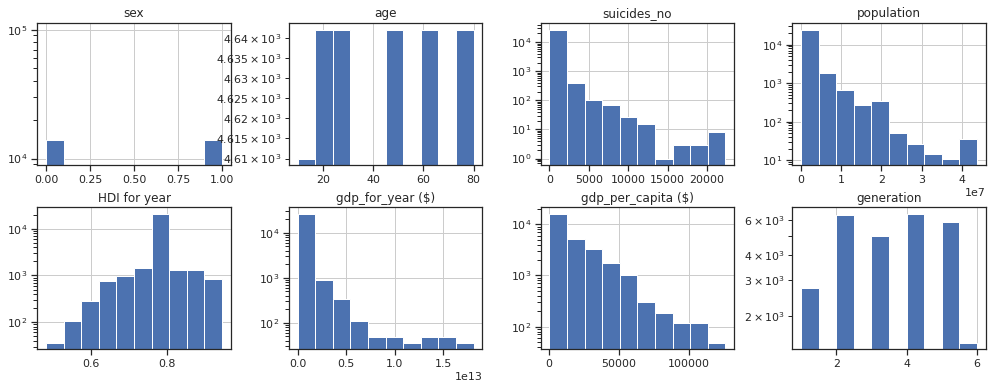

In [3]:
# Lets look at the histograms to check for mistakes in processing
hist = suicides_org.copy()
hist.hist(column=['sex', 'age', 'suicides_no', 'population', 'HDI for year',
                  'gdp_for_year ($)', 'gdp_per_capita ($)', 'generation'],
        log=True,
        figsize=(17, 6), layout=(2,4))

plt.show()

In [4]:
# Remove extra
suicides.drop(columns=['country', 'suicides_no', 'country-year', 'population', 'gdp_for_year ($)', 'gdp_per_capita ($)'], inplace=True)

display(suicides)

,year,sex,age,suicides/100k pop,HDI for year,generation
0,1987,1,20,6.71,0.776601,4
1,1987,1,45,5.19,0.776601,2
2,1987,0,20,4.83,0.776601,4
3,1987,1,80,4.59,0.776601,1
4,1987,1,30,3.28,0.776601,3
...,...,...,...,...,...,...
27815,2014,0,45,2.96,0.675000,4
27816,2014,0,80,2.58,0.675000,2
27817,2014,1,10,2.17,0.675000,6
27818,2014,0,10,1.67,0.675000,6


## 2. Split the dependent variable into two categories.

High and low like in the assignment 3 solution, but I'm going to make different cuts from high to low.

In [5]:
# Get stats
s_100k = suicides['suicides/100k pop'].values
y_mean = np.mean(s_100k)
y_std = np.std(s_100k)

In [6]:
# Get high/low splits @ 1/4 std, 1/2 std, 2/3 std, and 3/4 std
labels = ['Low', 'High']

# 1/4 std
target_1_4 = pd.cut(suicides['suicides/100k pop'], bins=[np.NINF, (y_mean + 1/4*y_std), np.Infinity], labels=labels)

# 1/2 std
target_1_2 = pd.cut(suicides['suicides/100k pop'], bins=[np.NINF, (y_mean + 1/2*y_std), np.Infinity], labels=labels)

# 2/3 std
target_2_3 = pd.cut(suicides['suicides/100k pop'], bins=[np.NINF, (y_mean + 2/3*y_std), np.Infinity], labels=labels)

# 3/4 std
target_3_4 = pd.cut(suicides['suicides/100k pop'], bins=[np.NINF, (y_mean + 3/4*y_std), np.Infinity], labels=labels)

targets = [target_1_4, target_1_2, target_2_3, target_3_4]

# Split/prepare the evaluation sets
X = suicides.loc[:, suicides.columns != 'suicides/100k pop'].values

Ys = []
for target in targets:
    vals = target.values
    le = LabelEncoder()
    vals = le.fit_transform(vals)
    Ys.append(vals)
    
Ys = {'1/4': Ys[0], '1/2': Ys[1], '2/3': Ys[2], '3/4': Ys[3]}

## 3./4. Develop and Evaluate models

Based on testing there is a drop off in return on accuracy when we restrict the "High" class is too restricted.

In [7]:
models = [RandomForestClassifier(max_depth=10, class_weight='balanced'),
          GaussianNB(), 
          DecisionTreeClassifier(max_depth=10, class_weight='balanced')]

# Adapted from module 3 soln.
def evaluate(model, x, y, score=f1_score):
    acc = []
    kf = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
    for train_index, test_index in kf.split(x, y):
        model.fit(x[train_index], y[train_index])
        y_pred = model.predict(x[test_index])
        acc += [score(y[test_index], y_pred, pos_label=0)]
        
    return np.array(acc)

In [8]:
# this cell chuggs. (As my prev. boss used to say "Shut'er down Earl, she's a-pumpin' mud.")
for model, y in product(models, Ys):
    acc = evaluate(model, X, Ys[y])
    
    print(f'Model: {model} Target Split: {y} Accuracy: {np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')
    

Model: RandomForestClassifier(class_weight='balanced', max_depth=10) Target Split: 1/4 Accuracy: 0.63 ±0.021
Model: RandomForestClassifier(class_weight='balanced', max_depth=10) Target Split: 1/2 Accuracy: 0.57 ±0.015
Model: RandomForestClassifier(class_weight='balanced', max_depth=10) Target Split: 2/3 Accuracy: 0.52 ±0.015
Model: RandomForestClassifier(class_weight='balanced', max_depth=10) Target Split: 3/4 Accuracy: 0.50 ±0.016
Model: GaussianNB() Target Split: 1/4 Accuracy: 0.58 ±0.034
Model: GaussianNB() Target Split: 1/2 Accuracy: 0.54 ±0.041
Model: GaussianNB() Target Split: 2/3 Accuracy: 0.50 ±0.040
Model: GaussianNB() Target Split: 3/4 Accuracy: 0.49 ±0.043
Model: DecisionTreeClassifier(class_weight='balanced', max_depth=10) Target Split: 1/4 Accuracy: 0.63 ±0.021
Model: DecisionTreeClassifier(class_weight='balanced', max_depth=10) Target Split: 1/2 Accuracy: 0.56 ±0.017
Model: DecisionTreeClassifier(class_weight='balanced', max_depth=10) Target Split: 2/3 Accuracy: 0.51 ±0.0

## 5. Predict with Designated Input

Designated input: year=2000, generation=Generation X, age=20, gender=male

Since I include HDI in my model I'm going to:

a.) predict with the mean HDI in Designated Input on a RandomForestClassifier

b.) drop HDI and predict on a RandomForestClassifier

The best classifier in 3./4. above was generally the __RandomForestClassifier__ with max_depth=10 and class_weight='balanced', so that is the one I'll be using here.

In [9]:
# The designated input
designated1 = np.array([[2000, 1, 20, HDI_mean, 4]])
designated2 = np.array([[2000, 1, 20, 4]])

# Drop HDI column from suicides
suicides.drop(columns='HDI for year', inplace=True)

# Gather into separate X array
X_no_hdi = suicides.loc[:, suicides.columns != 'suicides/100k pop'].values

# Declare our model, fit on all data, show prediction
best_model = RandomForestClassifier(max_depth=10, min_samples_leaf=1, class_weight='balanced')

# Function to run fit and prediction
def fit_and_predict(X_data, X_des, Y=Ys['1/2'], model=best_model):
    model.fit(X_data, Y)
    pred = model.predict(X_des)
    return pred

# Lambda to save some space in output
classify = lambda x: 'High Rate' if x[0] == 0 else 'Low Rate'

### With mean HDI in designated input

Typically indicates 'High Rate'

In [10]:
# Fit and predict
d1_pred = fit_and_predict(X, designated1)

# Show result
print(f"With HDI: {classify(d1_pred)}")

With HDI: High Rate


### With no HDI

Typically indicates 'High Rate' also

In [11]:
# Fit and predict
d2_pred = fit_and_predict(X_no_hdi, designated2)

# Show result
print(f"Without HDI: {classify(d2_pred)}")

Without HDI: High Rate


### Run through the High/Low splits

The two High/Low splits that produced more accurate results (1/4, 1/2) tend to indicate high rate for this input in both HDI included form and HDI excluded form.

In [12]:
# Run through with all High/Low splits

for y in Ys:
    this_pred = fit_and_predict(X, designated1, Y=Ys[y])
    that_pred = fit_and_predict(X_no_hdi, designated2, Y=Ys[y])
    
    print(f"W/ HDI {y} split: {classify(this_pred)}")
    print(f"W/o HDI {y} split: {classify(that_pred)}")

W/ HDI 1/4 split: High Rate
W/o HDI 1/4 split: High Rate
W/ HDI 1/2 split: High Rate
W/o HDI 1/2 split: High Rate
W/ HDI 2/3 split: Low Rate
W/o HDI 2/3 split: Low Rate
W/ HDI 3/4 split: High Rate
W/o HDI 3/4 split: Low Rate
